<a href="https://colab.research.google.com/github/MPGarg/ERA1_Session7/blob/main/ERA1S7E3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Attempt 3:**

Target:
*   Lower number of parameters (Meet our target of <=8000 Parameters)
*   Increase model capacity by adding Convolution layer afer GAP
*   Add Transformations
*   Use Step Learning to stablize results

Results:
*   Total Parameters: 7,944
*   Best Training Accuracy: 99.17%
*   Best Test Accuracy: 99.46%

Analysis:
*   Model was able to achieve it's target of 99.40% accuracy at 7th epoch and remained near/more than 99.40% after that.
*   Adding transformations like Random Rotation & Color Jitter helped the model to learn better and become more resilient.
*   Adding Convolution layer after GAP increased performance of model.
*   Step Learning with higher starting learning rate of and decent step size helped the model in learning fast and stabilizing accuracy in later stages.

# Import Libraries

In [69]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Transformations

*   Image Normalization


In [71]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.ElasticTransform(alpha=50.0, sigma=5.0, fill=0),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [72]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [73]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Sample Images

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

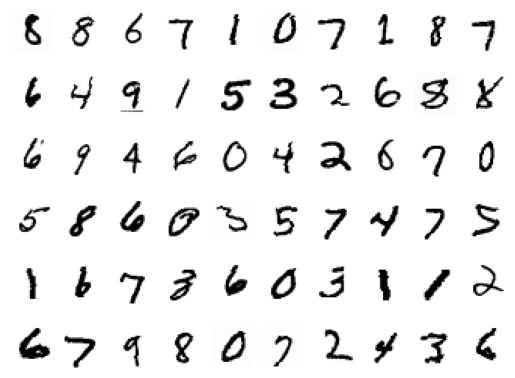

In [74]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [75]:
import model3
import utils

from model3 import *
from utils import *

# Model Params


In [76]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
       BatchNorm2d-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             150
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
          Dropout-14           [-1

# Training and Testing

We have 7.9k params for this model

In [82]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Train and Test of our model

In [83]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1 )
    train(model, device, train_loader, optimizer, epoch,train_losses, train_acc)
    scheduler.step()
    test(model, device, test_loader,test_losses, test_acc)

EPOCH: 1


Loss=0.14251624047756195 Batch_id=468 Accuracy=92.30: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0816, Accuracy: 9725/10000 (97.25%)

EPOCH: 2


Loss=0.10618960857391357 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0452, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.02332986705005169 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0379, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.06037446856498718 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]



Test set: Average loss: 0.0440, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.018925122916698456 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.0351882204413414 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0354, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.09579535573720932 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.016495903953909874 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]



Test set: Average loss: 0.0204, Accuracy: 9945/10000 (99.45%)

EPOCH: 9


Loss=0.1155431866645813 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:37<00:00, 12.43it/s]



Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.01106023509055376 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s]



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.02152263931930065 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]



Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.0483330637216568 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.0528656430542469 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s]



Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.02027515135705471 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:36<00:00, 12.69it/s]



Test set: Average loss: 0.0203, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.0067230346612632275 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]



Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)



In [84]:
train_losses1 = [t.cpu().item() for t in train_losses]

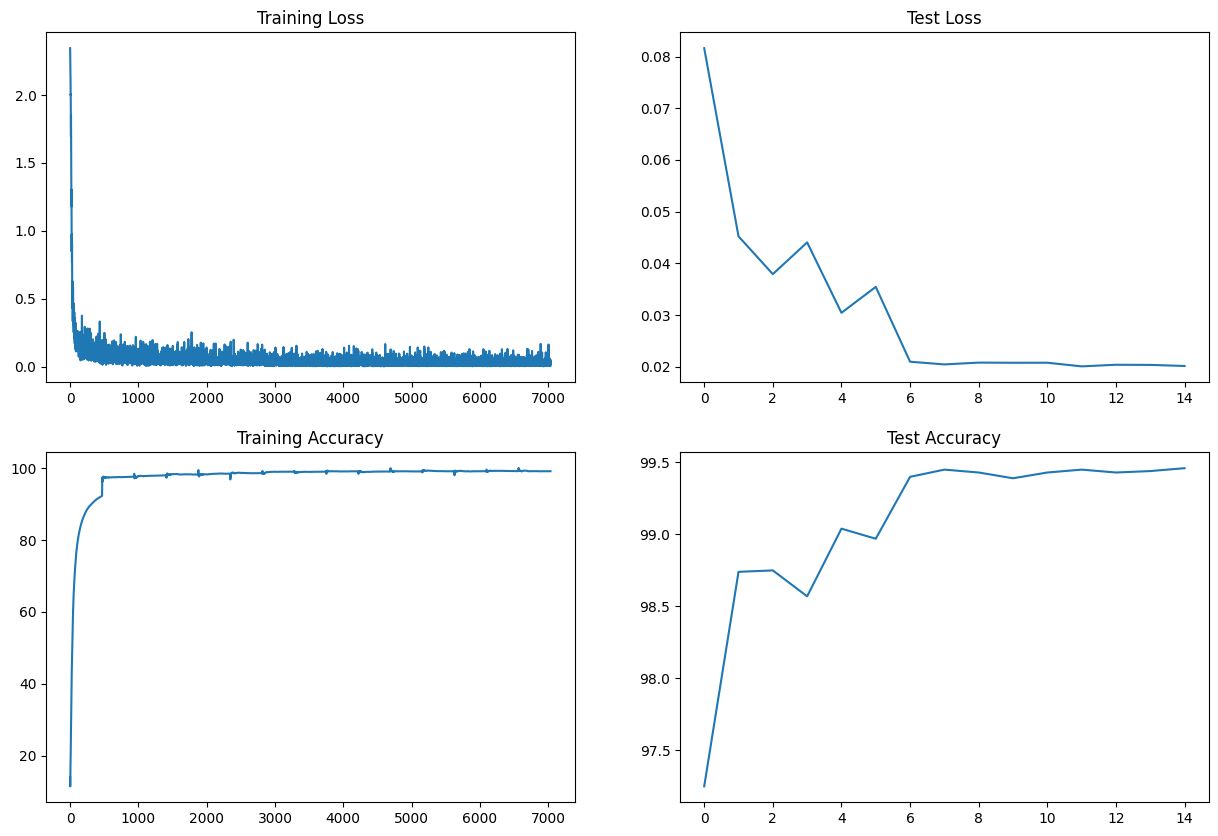

In [85]:
print_graph(train_losses1,train_acc, test_losses,test_acc)